In [1]:
%load_ext autoreload
%autoreload 2


## Setup

In [2]:
import jax
import numpy as np
import matplotlib.pyplot as plt 
import galsim as _galsim


In [3]:
jax.__version__, _galsim.__version__


('0.4.16', '2.5.0')

In [4]:
jax.devices()


[gpu(id=0), gpu(id=1), gpu(id=2), gpu(id=3)]

In [5]:
jax.config.update("jax_default_device", jax.devices()[0])


In [6]:
import jax
import jax.numpy as jnp
import jax_galsim as galsim
from jax import random

from jax import device_get, device_put


In [7]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random


/pscratch/sd/i/imendoza/miniconda3/envs/jax4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from tqdm import tqdm


In [9]:
import bpd
from bpd.chains import run_chains
from bpd.draw import add_noise


In [10]:
from numpyro.diagnostics import summary, gelman_rubin, effective_sample_size, print_summary


## Forward model

In [13]:
PSF_HLR = 0.7
PIXEL_SCALE = 0.2
SLEN = 51
BACKGROUND = 100

N_GAL = 2

# galaxy
TRUE_HLR = 0.9
LOG_TRUE_FLUX = 4.5
TRUE_FLUX = 10**LOG_TRUE_FLUX

# positions 
POS = jnp.array([[-5.0,0.0],
                 [7.5,0.0]]
               )
 
#shear (per bin)
G = jnp.array([[0.02, 0], 
               [-0.02, 0]]
             )

# which tomographic bin
N_TOMO = 2
TOMO_BINS = jnp.array([0, 1])

LF = jnp.array([LOG_TRUE_FLUX, LOG_TRUE_FLUX]) 
HLR = jnp.array([TRUE_HLR, TRUE_HLR])


assert len(TOMO_BINS) == POS.shape[0] == len(HLR) == len(LF) == N_GAL
assert len(jnp.unique(TOMO_BINS)) == G.shape[0] == N_TOMO



#params
TRUE_PARAMS = {'lfs': LF, 'hlrs': HLR, 'gs': G, 'poss': POS, 'tomo_bins':TOMO_BINS}
# TRUE_PARAMS_ARR = {k:jnp.array([v]) for k,v in TRUE_PARAMS.items()}


In [14]:
def _draw_gals():
    fim = np.zeros((SLEN, SLEN))
    for ii in range(N_GAL):
        gal = _galsim.Gaussian(flux=TRUE_FLUX, half_light_radius=TRUE_HLR)
        t = TOMO_BINS[ii]
        gal = gal.shear(g1=G[t, 0], g2=G[t, 1])
        dx, dy = POS[ii]
        pos = _galsim.PositionD(x=dx, y=dy)
        psf = _galsim.Gaussian(flux=1.0, half_light_radius=PSF_HLR)
        gal_conv = _galsim.Convolve([gal, psf])
        im = gal_conv.drawImage(nx=SLEN, ny=SLEN, scale=PIXEL_SCALE, offset=pos)
        fim += im.array

    return fim


In [15]:
GSPARAMS = galsim.GSParams(minimum_fft_size=512, maximum_fft_size=512)

@jax.jit
def draw_gals(lfs, hlrs,  gs, poss, tomo_bins):
    fim = jnp.zeros((SLEN, SLEN))
    for ii in range(N_GAL):
        lf = lfs[ii] 
        hlr = hlrs[ii]
        x, y = poss[ii]
        t = tomo_bins[ii]
        g1, g2 = gs[t]
        
        gal = galsim.Gaussian(flux=10**lf, half_light_radius=hlr)
        gal = gal.shear(g1=g1, g2=g2)
        
        pos = galsim.PositionD(x=x, y=y)
        psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
        gal_conv = galsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
        image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                               offset=pos, 
                               )
        fim += image.array
    return fim



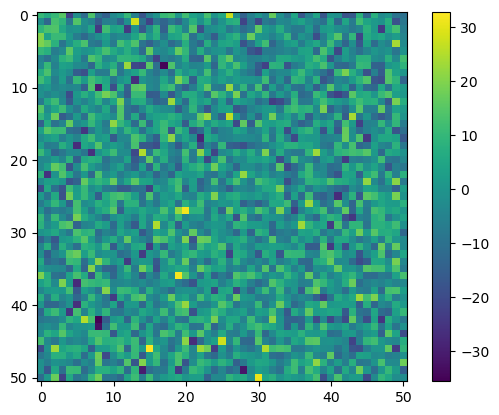

In [16]:
# check error is very small on true thingies
TRUE_IMAGE = _draw_gals()
image, _ = add_noise(TRUE_IMAGE, BACKGROUND, n=1)
arr = image[0] - draw_gals(**TRUE_PARAMS)
plt.imshow(arr)
plt.colorbar()


In [17]:
import math
def prob_model(data):
    # global shears, one per tomo bin.
    g11 = numpyro.sample("g11", dist.Uniform(-0.1, 0.1))
    g12 = numpyro.sample("g12", dist.Uniform(-0.1, 0.1))
    g21 = numpyro.sample("g21", dist.Uniform(-0.1, 0.1))
    g22 = numpyro.sample("g22", dist.Uniform(-0.1, 0.1))
    g = jnp.array([[g11, g12], [g21, g22]]).reshape((2, 2))

    with numpyro.plate("n", N_GAL, dim=-1):
        lf = numpyro.sample("lf", dist.Uniform(3, 6))
        hlr = numpyro.sample("hlr", dist.Uniform(0.5, 1.5))

    im = draw_gals(lf, hlr, g, POS, TOMO_BINS)
    numpyro.sample("obs", dist.Normal(im, math.sqrt(BACKGROUND)), obs=data)

In [40]:
from numpyro.infer.initialization import init_to_median

data, _ = add_noise(TRUE_IMAGE, BACKGROUND, n=1)
nuts_kernel = NUTS(prob_model, max_tree_depth=10, 
                    init_strategy=init_to_median, 
                   # find_heuristic_step_size=True
            )
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=4000, 
            num_chains=1, chain_method="sequential")
rng_key = random.PRNGKey(4)
mcmc.run(rng_key, data=data[0])


warmup:  10%|█         | 507/5000 [00:31<04:37, 16.18it/s, 15 steps of size 2.16e-01. acc. prob=0.79] 


KeyboardInterrupt: 

In [32]:
from bpd.chains import run_chains
data, _ = add_noise(TRUE_IMAGE, BACKGROUND, n=2)
_samples = run_chains(data, nuts_kernel, n_vec = 1, n_warmup=10, n_samples=10, seed=0)

sample: 100%|██████████| 20/20 [00:02<00:00,  6.75it/s, 3 steps of size 2.84e-03. acc. prob=0.34]


In [33]:
_samples['g11'].shape, _samples['lf'].shape

((2, 10, 1), (2, 10, 2))

In [20]:
# snapshot
samples = mcmc.get_samples(group_by_chain=False)
# samples['g11'][:, 3, 0].mean(), samples['g21'][:, 3, 0].mean(), samples['g11'][:, 3, 0].std(), samples['g21'][:, 3, 0].std()

In [36]:
print_summary(mcmc.get_samples(), group_by_chain=False)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       g11      0.03      0.01      0.03      0.02      0.05   4041.61      1.00
       g12      0.01      0.01      0.01     -0.01      0.02   3374.21      1.00
       g21     -0.02      0.01     -0.02     -0.04     -0.01   3867.33      1.00
       g22      0.01      0.01      0.01     -0.01      0.02   3570.88      1.00
    hlr[0]      0.90      0.01      0.90      0.89      0.91   2848.33      1.00
    hlr[1]      0.90      0.01      0.90      0.89      0.92   3439.72      1.00
     lf[0]      4.50      0.00      4.50      4.49      4.51   2837.98      1.00
     lf[1]      4.50      0.00      4.50      4.50      4.51   3022.35      1.00



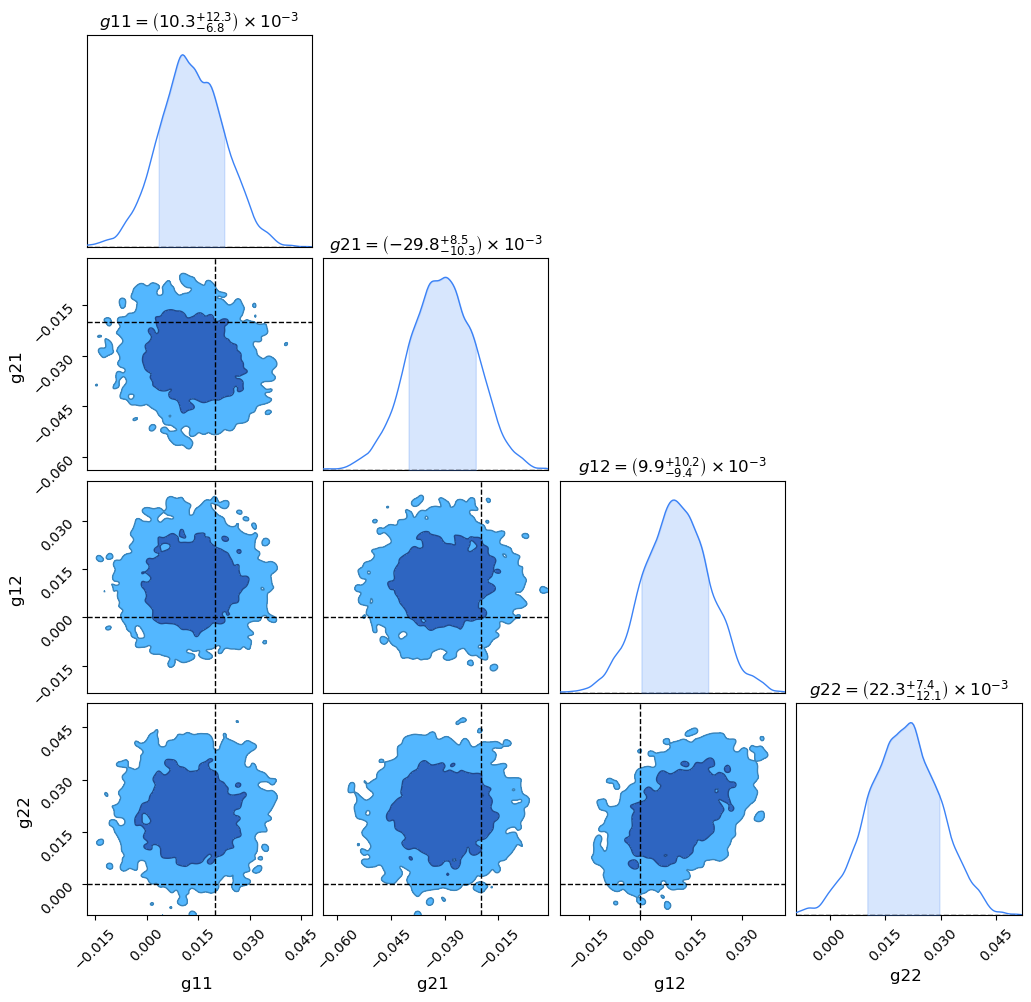

In [23]:
# example of corner plots for 1 chain
from chainconsumer import ChainConsumer, Truth, Chain
import pandas as pd
c = ChainConsumer()
_samples = {k:samples[k] for k in ['g11', 'g21', 'g12', 'g22']}
df =pd.DataFrame.from_dict(_samples)
c.add_chain(
    Chain(samples=df,
    name='Posterior')
)
c.add_truth(Truth(location={'g11':0.02, 'g21':-0.02, 'g12': 0.00, 'g22':0.00}))
fig = c.plotter.plot()

In [27]:
# samples = {k:v.reshape(4, 4000, -1) for k,v in mcmc.get_samples(group_by_chain=True).items()}
# samples0 = {k:v.reshape(4, 4000, -1)[0].squeeze() for k,v in mcmc.get_samples(group_by_chain=True).items()}
# samples['g11'].shape, samples['lf'].shape

In [24]:
# diagnostics for multiple chains ( >= 4) 
from numpyro.diagnostics import split_gelman_rubin, gelman_rubin

print('gelman-rubin')
for k in ['g11', 'g21', 'g12', 'g22']:
    print(k, gelman_rubin(samples[k]), _gelman_rubin(samples[k][:,:]))
print()



gelman-rubin


AssertionError: 

In [55]:
jax.local_device_count()

4

In [26]:
data[0:1].shape

(1, 51, 51)

In [2]:
from bpd.save_load import load_samples
samples = load_samples('../experiments/samples/two_shears.hdf5', groups=['run_1'])

In [5]:
samples['run_1']['g11'].shape

(3, 10, 1)